<a href="https://colab.research.google.com/github/gyeoldere/MuTube/blob/master/clustering_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install konlpy
!pip install mglearn
!pip install gluonnlp
!pip install mxnet
!pip install transformers==2.4.1

     |████████████████████████████████| 19.4MB 1.4MB/s 
     |████████████████████████████████| 92kB 11.5MB/s 
     |████████████████████████████████| 460kB 51.7MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
     |████████████████████████████████| 542kB 9.0MB/s 
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582639 sha256=72beea14fac173117dd739f67ce016c8e28cc0eaa06b3d4f724d387ed7b542e3
  Stored in directory: /root/.cache/pip/wheels/eb/a6/ea/a6a3716233fa62fc561259b5cb1e28f79e9ff3592c0adac5f0
Successfully built mglearn
     |████████████████████████████████| 348kB 8.1MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp36-cp36m-linux_x86_64.whl size=588505 sha256=ced947df3c61543510cfc1d23fbea9ef088817d704e450441417121c7aa9e3d5
  S

In [2]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.cluster import KMeans
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import mglearn
from sklearn.cluster import AgglomerativeClustering
import sys
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
import random

In [3]:
!gdown --id 1CKmd6EheRX_o1_wHm32GoHMQlUkxTD3E

Downloading...
From: https://drive.google.com/uc?id=1CKmd6EheRX_o1_wHm32GoHMQlUkxTD3E
To: /content/JAM.csv
8.12MB [00:00, 71.4MB/s]


In [4]:
data = pd.read_csv("JAM.csv", engine='python',encoding='CP949')

In [186]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 분석

In [5]:
train_data = pd.DataFrame(data)

In [6]:
train_data.head(3) # 데이터 구성요소

,년도,가수,제목,성별,장르,최고순위,작사,작곡,소속사,가사
0,19920000,잼,난 멈추지 않는다,mixed,댄스,1,조진호,조진호,DSP 미디어,이제 모든걸 다시 시작해 내겐 아직도 시간이 있어 때론 상처가 좌절로 남아 돌이킬수...
1,19920000,잼,우리 모두 사랑하자,mixed,댄스,7,조진수,조진수,DSP 미디어,워 우리 모두 사랑하자 우리의 젊은날을 위하여 우리 모두 춤을 추자 가벼운 인스텝 ...
2,19920000,잼,이유,mixed,발라드,0,조진호,조진호,DSP 미디어,어둠은 드리워지고 이제는 우리들만의 시간이 지친듯이 내 가슴속에 밀려와 나를 재우고...


In [7]:
train_data.shape[0] # 곡 수

5619

In [8]:
len(train_data['가수'].unique()) # 유니크한 가수의 수

454

In [9]:
train_data.columns # 특성 목록

Index(['년도', '가수', '제목', '성별', '장르', '최고순위', '작사', '작곡', '소속사', '가사'], dtype='object')

In [10]:
# 각 attribute에 따른 N/A값의 수
for attribute in train_data.columns:
    print(train_data[attribute].isnull().sum())
    

0
0
0
0
0
0
41
52
99
1


위 셀에서 소속사가 없는 가수에 대한 정보가 다수 포함되어 있음을 알 수 있음.



클러스터링 단계에서는 가사만 사용되므로, 가사가 N/A값인 데이터만 삭제.

In [11]:
train_data = train_data[train_data['가사'].notnull()]

In [12]:
train_data.head(3)

,년도,가수,제목,성별,장르,최고순위,작사,작곡,소속사,가사
0,19920000,잼,난 멈추지 않는다,mixed,댄스,1,조진호,조진호,DSP 미디어,이제 모든걸 다시 시작해 내겐 아직도 시간이 있어 때론 상처가 좌절로 남아 돌이킬수...
1,19920000,잼,우리 모두 사랑하자,mixed,댄스,7,조진수,조진수,DSP 미디어,워 우리 모두 사랑하자 우리의 젊은날을 위하여 우리 모두 춤을 추자 가벼운 인스텝 ...
2,19920000,잼,이유,mixed,발라드,0,조진호,조진호,DSP 미디어,어둠은 드리워지고 이제는 우리들만의 시간이 지친듯이 내 가슴속에 밀려와 나를 재우고...


In [13]:
print(train_data['가사'].isnull().sum())

0


# 데이터 정제

In [14]:
# 중복된 가사 확인
train_data.shape[0] - train_data['가사'].nunique()

0

1605개 중복된 데이터가 있음을 확인


In [15]:
# 중복된 가사 제거
train_data.drop_duplicates(subset=['가사'], inplace=True)

In [16]:
len(train_data) - train_data['가사'].nunique()

0

In [17]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 5618


In [18]:
'년도', '가수', '제목', '성별', '장르', '최고순위', '작사', '작곡', '소속사', '가사'
titles = train_data['제목'].reset_index()
groups = train_data['가수'].reset_index()

titles_groups = pd.concat([titles, groups],axis=1)

# 각 데이터를 따로 구하고 싶으면 다음 주석을 해제하여 사용
'''
groups = train_data['년도'].reset_index()
groups = train_data['장르'].reset_index()
groups = train_data['성별'].reset_index()
groups = train_data['최고순위'].reset_index()
groups = train_data['작사'].reset_index()
groups = train_data['작곡'].reset_index()
groups = train_data['소속사'].reset_index()
'''

# 전처리가 끝난 전체 dataframe을 사용하고 싶을 때
train_data_all = train_data

train_data = train_data['가사'].reset_index()

# 데이터 전처리

이모티콘을 포함한 특수문자 모두 제거

In [19]:
train_data['가사'] = train_data['가사'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z ]","")
train_data[:5]

,index,가사
0,0,이제 모든걸 다시 시작해 내겐 아직도 시간이 있어 때론 상처가 좌절로 남아 돌이킬수...
1,1,워 우리 모두 사랑하자 우리의 젊은날을 위하여 우리 모두 춤을 추자 가벼운 인스텝 ...
2,2,어둠은 드리워지고 이제는 우리들만의 시간이 지친듯이 내 가슴속에 밀려와 나를 재우고...
3,3,끝없는 어둠 속을 천천히 걷고 있어 어디서 본 듯한 야릇한 느낌이야 거리는 비에 젖...
4,4,요즘 친구들은 흥 정말 진정한 친구가 뭔지 잘 몰라 말로만 떠들고 자기들이 다만 그...


In [20]:
# 아무 것도 남지 않은 데이터 N/A로 변경
train_data['가사'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

index    0
가사       0
dtype: int64


In [21]:
# 문장부호들을 제거하는 것으로 생긴 N/A값들 모두 제거
train_data = train_data.dropna(how = 'any')

In [22]:
train_data_all[:4]

,년도,가수,제목,성별,장르,최고순위,작사,작곡,소속사,가사
0,19920000,잼,난 멈추지 않는다,mixed,댄스,1,조진호,조진호,DSP 미디어,이제 모든걸 다시 시작해 내겐 아직도 시간이 있어 때론 상처가 좌절로 남아 돌이킬수...
1,19920000,잼,우리 모두 사랑하자,mixed,댄스,7,조진수,조진수,DSP 미디어,워 우리 모두 사랑하자 우리의 젊은날을 위하여 우리 모두 춤을 추자 가벼운 인스텝 ...
2,19920000,잼,이유,mixed,발라드,0,조진호,조진호,DSP 미디어,어둠은 드리워지고 이제는 우리들만의 시간이 지친듯이 내 가슴속에 밀려와 나를 재우고...
3,19920000,잼,18번가의 비밀,mixed,댄스,0,조진호,조진호,DSP 미디어,끝없는 어둠 속을 천천히 걷고 있어 어디서 본 듯한 야릇한 느낌이야 거리는 비에 젖...


# 토크나이징


불용어 지정

In [23]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [24]:
okt = Okt()

In [59]:
 train_data['가사'][0]

'이제 모든걸 다시 시작해 내겐 아직도 시간이 있어 때론 상처가 좌절로 남아 돌이킬수 없는 후회도 하고  그러나 우리 잊어선 안돼 지금의 나는 내가 아닌걸 신문에 실려온 얘기들 헝클어진 우리들을 탓할순 없어  이제 모든걸 다시 시작해 이렇게 여기서 끝낼순 없어 내겐 아직도 시간이 있어 지금 이렇게 지금 멈출수는 없어  신문에 실려온 얘기들 헝클어진 우리들을 탓할순 없어  이제 모든걸 다시 시작해 이렇게 여기서 끝낼순 없어 내겐 아직도 시간이 있어 지금 이렇게 지금  나는 여기서 멈출순 없어 이제 모든걸 다시 시작해 나는 여기서 멈출순 없어 이제 모든걸 다시 시작해'

(1회용) Okt를 사용, 형태소 단위로 단어 분류, 일정 수준의 정규화 실행

In [25]:
'''
X_train = []
for sentence in train_data['가사']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)
'''

"\nX_train = []\nfor sentence in train_data['가사']:\n    temp_X = []\n    temp_X = okt.morphs(sentence, stem=True) # 토큰화\n    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거\n    X_train.append(temp_X)\n"

(1회용) 토큰화한 X_test를 저장합니다.

In [26]:
'''
X_train_nparray = np.array(X_train)
np.save('./X_train',X_train_nparray)
'''

"\nX_train_nparray = np.array(X_train)\nnp.save('./X_train',X_train_nparray)\n"

X_train을 불러옵니다.

In [27]:
!gdown --id 1VX-lIGMWgD4K9Mz-0SUJA-JZAtBodZld

Downloading...
From: https://drive.google.com/uc?id=1VX-lIGMWgD4K9Mz-0SUJA-JZAtBodZld
To: /content/X_train.npy
22.3MB [00:00, 136MB/s] 


In [28]:
X_train = np.load('./X_train.npy',allow_pickle=True).tolist()

In [ ]:
X_train[0]

# word2vec

모델 훈련은 완료했으나, 인접 행렬을 구하는데 시간과 자원이 너무 소모됨. > doc2vec로 방향 선회

In [ ]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = X_train, size = 200, window = 5, min_count = 2, workers = 4, sg = 0)

In [ ]:
len(model.wv.vocab)

18548

In [ ]:
vocab = model.wv.vocab
sorted(vocab, key=vocab.get, reverse=True)[:10]

['너', '내', '을', '나', 'you', '있다', '보다', '사랑', 'I', '없다']

In [ ]:
model.wv.most_similar('너')

In [ ]:
model.wv.most_similar('여자친구')

In [ ]:
model.wv.wmdistance(X_train[0], X_train[1])

10.254282990220695

In [ ]:
%time model.wv.wmdistance(X_train[0], X_train[2])

CPU times: user 42.3 ms, sys: 2 µs, total: 42.3 ms
Wall time: 41.9 ms


9.54089145649308

In [ ]:
# 인접 행렬 구하기

Adjacency_Matrix = np.zeros((5628,5628))
for i in range(5628):
    for j in range(1):
        Adjacency_Matrix[i][j] = model.wv.wmdistance(X_train[i], X_train[j])


KeyboardInterrupt: ignored

# Doc2vec

In [30]:
#common_texts_and_tags = [(text, [train_data_all['제목'][train_data_all.index[i]], train_data_all['가수'][train_data_all.index[i]],train_data_all['장르'][train_data_all.index[i]],train_data_all['소속사'][train_data_all.index[i]]],) for i, text in enumerate(X_train)]

In [31]:
common_texts_and_tags = [
    (text, [train_data_all['제목'][train_data_all.index[i]], train_data_all['가수'][train_data_all.index[i]]],) for i, text in enumerate(X_train)]

In [32]:
# common_texts_and_tags[:10]

In [33]:
TRAIN_documents = [TaggedDocument(words=text, tags=tags) for text, tags in common_texts_and_tags]

모델을 훈련시킵니다.

In [34]:
model = Doc2Vec(TRAIN_documents, vector_size=100, window=3, epochs=40, min_count=0, workers=4)

모델을 저장합니다.

In [41]:

model_name = "doc2vec_100,5,40,1,4"
model.save(model_name)


저장된 모델을 다운받아 불러옵니다.

In [ ]:
# !gdown --id 1YJS5FRX-ODSZsYJz8j0roz6rVeQ9K2pL #doc2vec_5,3,40,0,4

Downloading...
From: https://drive.google.com/uc?id=1YJS5FRX-ODSZsYJz8j0roz6rVeQ9K2pL
To: /content/doc2vec_5,3,40,0,4
3.96MB [00:00, 126MB/s]


In [29]:
!gdown --id 1_EwBspXfSyOJI9kEaQOYdreygDl42IVK #doc2vec_100,5,40,1,4

Downloading...
From: https://drive.google.com/uc?id=1_EwBspXfSyOJI9kEaQOYdreygDl42IVK
To: /content/doc2vec_100,5,40,1,4
38.2MB [00:00, 49.9MB/s]


In [30]:
model = Doc2Vec.load("doc2vec_100,5,40,1,4")

In [ ]:
# model.docvecs.doctags

# K_means 클러스터링

클러스터링 전처리

In [ ]:
import copy 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data_all['가수'])
X_singer = tokenizer.texts_to_sequences(train_data_all['가수'])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data_all['장르'])
X_genre = tokenizer.texts_to_sequences(train_data_all['장르'])

X2 = [] 
for n,x in enumerate(model.docvecs.vectors_docs):
    temp = []

    # for element in x: temp.append(element)
    temp.append(X_genre[n][0])
    temp.append(X_singer[n][0])
    
    X2.append(temp)

X3 = np.array(X2)

In [ ]:
print("K-Means Clustering")


M_KMeans = KMeans(n_clusters=8, random_state=0)
X = X3 # document vector 전체를 가져옴. 
M_KMeans.fit(X)# fitting 

'''
M_KMeans = KMeans(n_clusters=8, random_state=0)
X = model.docvecs.vectors_docs # document vector 전체를 가져옴. 
M_KMeans.fit(X)# fitting 
'''
 
cluster_dict = {i:[] for i in range(0,8)}
for text_tags, label in zip(common_texts_and_tags, M_KMeans.labels_):
    text, tags = text_tags
    cluster_dict[label].append([tags, text])

'''
for label, lst in cluster_dict.items():
    print(f"Cluster {label}")
    for x in lst:
        print(x)
'''


K-Means Clustering


'\nfor label, lst in cluster_dict.items():\n    print(f"Cluster {label}")\n    for x in lst:\n        print(x)\n'

In [ ]:
unique, counts = np.unique(M_KMeans.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 697, 1: 244, 2: 397, 3: 122, 4: 2120, 5: 526, 6: 66, 7: 1339}

In [ ]:
list(train_data_all['제목'][train_data_all['제목']=='My Life'].index)

[648, 890]

In [ ]:
list(train_data_all['가수'][train_data_all['가수']=='레드삭스'].index)

[888, 889, 890, 891, 892, 893]

In [ ]:
gasas = []
cluster_n = [] 
for clster in range(len(cluster_dict)):
    #print('cluster ' + str(clster))
    cluster_n_song = []
    gasa = []
    for song in cluster_dict[clster]:   
        temp1 = list(train_data_all['제목'][train_data_all['제목']==song[0][0]].index)
        temp2 = list(train_data_all['가수'][train_data_all['가수']==song[0][1]].index)
        
        for title in temp1:
            x = -1
            if title in temp2:
               x = title
               break

        #print(train_data_all['제목'][x])
        #print(train_data_all['장르'][x])
        #print(train_data_all['가수'][x])
        gasa.append(train_data_all['가사'][x])
        cluster_n_song.append([train_data_all['장르'][x],train_data_all['가수'][x],train_data_all['소속사'][x],int(train_data_all['년도'][x]/10000),train_data_all['작곡'][x]])
    cluster_n.append(cluster_n_song)
    gasas.append(gasa)


# Agglomerative 클러스터링

In [ ]:
print("Agglomerative Clustering")

n_clusters = 10

M_Agglo = AgglomerativeClustering(linkage='ward',
        connectivity=None, n_clusters=n_clusters)

X = model.docvecs.vectors_docs

result= M_Agglo.fit_predict(X3)

Agglomerative Clustering


In [ ]:
unique, counts = np.unique(result, return_counts=True)
dict(zip(unique, counts))

{0: 485,
 1: 827,
 2: 137,
 3: 932,
 4: 69,
 5: 1137,
 6: 208,
 7: 288,
 8: 38,
 9: 1390}

In [ ]:
cluster_dict1 = []
for i in range(n_clusters):
    cluster_dict1.append([])
    
for n, i in enumerate(result):
    text, tags = common_texts_and_tags[n]
    cluster_dict1[i].append([tags, text])

In [ ]:
gasas = []
cluster_n = [] 
for clster in range(len(cluster_dict1)):
    #print('cluster ' + str(clster))
    cluster_n_song = []
    gasa = []
    for song in cluster_dict1[clster]:   
        temp1 = list(train_data_all['제목'][train_data_all['제목']==song[0][0]].index)
        temp2 = list(train_data_all['가수'][train_data_all['가수']==song[0][1]].index)
        
        for title in temp1:
            x = -1
            if title in temp2:
               x = title
               break

        #print(train_data_all['제목'][x])
        #print(train_data_all['장르'][x])
        #print(train_data_all['가수'][x])
        gasa.append(train_data_all['가사'][x])
        cluster_n_song.append([train_data_all['장르'][x],train_data_all['가수'][x],train_data_all['소속사'][x],int(train_data_all['년도'][x]/10000),train_data_all['작곡'][x]])
    cluster_n.append(cluster_n_song)
    gasas.append(gasa)


# 클러스터링 형태소 분석

In [ ]:
sentences_tag_n = []
for n, cluster in enumerate(gasas):
    sentences_tag = []
    for sentence in cluster:
        morph = okt.pos(sentence)
        sentences_tag.append(morph)
    sentences_tag_n.append(sentences_tag)
print(len(sentences_tag_n))

In [ ]:
noun_adj_list_n = []
for i in range(len(sentences_tag_n)):
    noun_adj_list = []
    for sentence1 in sentences_tag_n[i]:
        for word, tag in sentence1:
            if tag in ['Noun','Adjective']:
                noun_adj_list.append(word)
    noun_adj_list_n.append(noun_adj_list)



In [ ]:
banlist = ['사랑','우리','그대','나','너','내']
for n in (noun_adj_list_n):
    for i,v in enumerate(n):
        if len(v) <2:
            n.pop(i)
            continue
        if v in banlist:
            n.pop(i)
            continue

In [ ]:
noun_adj_list_n[0]

In [ ]:
import matplotlib.font_manager as fm

# !apt -qq -y install fonts-nanum > /dev/null
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
fm._rebuild()
%config InlineBackend.figure_format = 'retina'
# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
from collections import Counter
from wordcloud import WordCloud
for n in (noun_adj_list_n):
    counts = Counter(n)
    print(counts.most_common(10))
    '''
    wc = WordCloud(font_path= fontpath, background_color='white', width=800, height=600)
    print(dict(counts))
    cloud = wc.generate_from_frequencies(dict(counts))
    plt.figure(figsize=(10, 8))
    plt.axis('off')
    plt.imshow(cloud)
    plt.show()
    '''

[('너', 1759), ('내', 1471), ('나', 1119), ('사랑', 860), ('난', 748), ('날', 702), ('말', 677), ('널', 547), ('더', 540), ('네', 517)]
[('너', 3804), ('내', 3329), ('나', 2441), ('사랑', 2026), ('난', 1650), ('말', 1405), ('날', 1382), ('그', 1227), ('널', 1167), ('그대', 1020)]
[('너', 239), ('나', 170), ('사랑', 162), ('내', 148), ('난', 116), ('말', 98), ('그대', 95), ('그', 90), ('날', 78), ('네', 74)]
[('너', 3972), ('내', 3306), ('나', 2563), ('사랑', 1925), ('난', 1692), ('날', 1454), ('말', 1327), ('널', 1215), ('그', 1213), ('수', 986)]
[('너', 3255), ('내', 2494), ('나', 1899), ('사랑', 1616), ('난', 1220), ('날', 1155), ('말', 1028), ('널', 957), ('그', 943), ('더', 795)]
[('너', 2208), ('내', 1764), ('나', 1312), ('난', 935), ('사랑', 912), ('날', 786), ('말', 762), ('네', 648), ('그', 594), ('수', 578)]
[('너', 2592), ('내', 2281), ('나', 1735), ('사랑', 1174), ('난', 1136), ('날', 1013), ('말', 927), ('그', 913), ('널', 746), ('네', 702)]
[('너', 1813), ('내', 1531), ('나', 1171), ('사랑', 853), ('난', 842), ('날', 694), ('말', 650), ('널', 607), ('더', 541)

# 클러스터링 데이터 분석

In [ ]:
import operator

for n, cluster in enumerate(cluster_n):
    tags_genre = {}
    tags_singer = {}
    tags_house = {}
    tags_time = {}
    tags_composer = {}

    for tag_n in cluster:
        if tag_n[0] not in tags_genre.keys():
            tags_genre[tag_n[0]] = 1
        else:
            tags_genre[tag_n[0]] += 1
        
        if tag_n[1] not in tags_singer.keys():
            tags_singer[tag_n[1]] = 1
        else:
            tags_singer[tag_n[1]] += 1

        if tag_n[2] not in tags_house.keys():
            tags_house[tag_n[2]] = 1
        else:
            tags_house[tag_n[2]] += 1

        if tag_n[3] not in tags_time.keys():
            tags_time[tag_n[3]] = 1
        else:
            tags_time[tag_n[3]] += 1

        if tag_n[4] not in tags_composer.keys():
            tags_composer[tag_n[4]] = 1
        else:
            tags_composer[tag_n[4]] += 1
        
    print("cluster " + str(n))
    print(len(cluster))
    print(sorted(tags_genre.items(), key=operator.itemgetter(1),reverse=True))
    print(sorted(tags_singer.items(), key=operator.itemgetter(1),reverse=True))
    print(sorted(tags_house.items(), key=operator.itemgetter(1),reverse=True))
    print(sorted(tags_time.items(), key=operator.itemgetter(1),reverse=True))  
    print(sorted(tags_composer.items(), key=operator.itemgetter(1),reverse=True))  

cluster 0
485
[('댄스', 269), ('발라드', 89), ('R&B/Soul', 39), ('랩/힙합', 37), ('록/메탈', 18), ('발라드, 국내드라마', 14), ('포크/블루스', 4), ('인디음악, 포크/블루스', 3), ('인디음악, 록/메탈', 2), ('댄스, 랩/힙합', 2), ('일렉트로니카', 2), ('발라드, 댄스', 1), ('국내드라마', 1), ('댄스, 국내드라마', 1), ('포크/블루스, 국내드라마', 1), ('발라드, R&B/Soul, 국내드라마', 1), ('록/메탈, 국내드라마', 1)]
[('투야', 11), ('에이스타일', 11), ('엠블랙', 11), ('이효리', 11), ('인피니트H', 11), ('빅스LR', 11), ('보이스립', 10), ('제이하트', 10), ('시크릿', 10), ('비에이 (Be.A)', 10), ('풍뎅이 (PDE)', 10), ('맵식스 (MAP6)', 10), ('지코 (ZICO)', 10), ('AKMU (악동뮤지션)', 10), ('Zion.T', 10), ('쿨 (COOL)', 9), ('핑클 (Fin.K.L)', 9), ('티티마', 9), ('배틀', 9), ('투에이엠', 9), ('애프터 스쿨', 9), ('2NE1', 9), ('인피니트', 9), ('씨스타', 9), ('허각', 9), ('칠학년일반', 9), ('Crush', 9), ('폴킴', 9), ('투애니원', 8), ('씨엔블루', 8), ('어반자카파', 8), ('장범준', 8), ('Circle', 7), ('에프엑스', 7), ('케이윌', 7), ('미쓰에이', 7), ('10CM', 7), ('울랄라세션', 7), ('백예린', 7), ('청하', 7), ('H.O.T.', 6), ('에스이에스', 6), ('보이 클럽', 6), ('보이스코', 6), ('레드삭스', 6), ('f(x)', 6), ('지나', 6), ('이하이', 6), ('LC9', 6)

In [ ]:
cluster_tags = []
cluster_tags.append(['다시 한번','숨은'])
cluster_tags.append(['지나간','옛날','추억의'])
cluster_tags.append(['그리움','아이돌'])
cluster_tags.append(['신나는','메탈'])
cluster_tags.append(['드라마틱','발라드','밤'])
cluster_tags.append(['대중적','아이돌','다양한'])
cluster_tags.append(['2세대','노인돌'])
cluster_tags.append(['1세대','들어본'])
cluster_tags.append(['힙한','감각적인'])
cluster_tags.append(['랩','유영진','이국적인'])



In [ ]:

cluster_tags_save = np.array(cluster_tags)
np.save('./cluster_tags_save',cluster_tags_save)
np.save('./cluster_dict',cluster_dict1)


n

In [ ]:
!gdown --id 1cIZmkllhoNDu5011_qia1YpswNVRckUT
!gdown --id /1EUBeEHMPDBkfLTK9Hq0aMXwzrjDKJ48l

cluster_tags_save1 = np.load('./cluster_tags_save.npy',allow_pickle=True)
if np.array_equal(cluster_tags_save1,cluster_tags_save):
    print('Wa')

Wa


In [ ]:
cluster_tags

[['다시 한번', '숨은'],
 ['지나간', '옛날', '추억의'],
 ['그리움', '아이돌'],
 ['신나는', '메탈'],
 ['드라마틱', '발라드', '밤'],
 ['1세대', '아이돌'],
 ['힙한', '감각적인'],
 ['랩', '유영진', '이국적인']]

In [ ]:
cluster_dict[0][0][1]

In [ ]:
sys.setrecursionlimit(10000)

print("hierarchical Clustering")

X = model.docvecs.vectors_docs

linked = linkage(X, 'ward')


hierarchical Clustering


In [ ]:
linked

array([[5.19700000e+03, 5.19800000e+03, 3.31226872e-02, 2.00000000e+00],
       [4.73900000e+03, 4.74000000e+03, 3.34883817e-02, 2.00000000e+00],
       [4.79400000e+03, 4.79500000e+03, 3.40015215e-02, 2.00000000e+00],
       ...,
       [1.03840000e+04, 1.04160000e+04, 1.28452031e+02, 2.45900000e+03],
       [1.04140000e+04, 1.04180000e+04, 1.36193555e+02, 4.31800000e+03],
       [1.04170000e+04, 1.04190000e+04, 2.46732698e+02, 5.21100000e+03]])

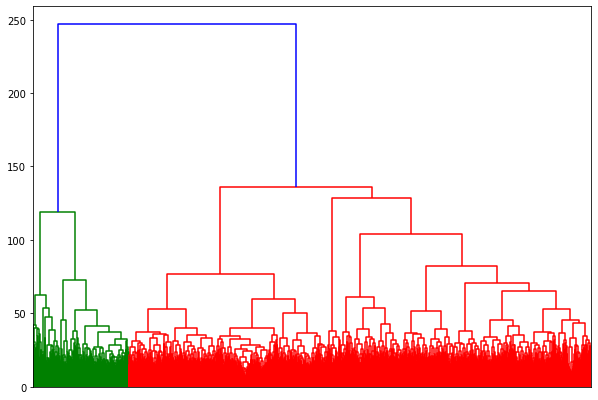

In [ ]:
labelList = range(1, 11)

plt.figure(figsize=(10, 7))
dendrogram(linked,no_labels=True)
plt.show()

# 완료된 클러스터링 데이터 불러오기

In [42]:
#클러스터링 태그
!gdown --id 1cIZmkllhoNDu5011_qia1YpswNVRckUT 

#클러스터링 데이터
!gdown --id 1EUBeEHMPDBkfLTK9Hq0aMXwzrjDKJ48l


cluster_tags_save = np.load('./cluster_tags_save.npy',allow_pickle=True)
cluster_dict = np.load('./cluster_dict.npy',allow_pickle=True)

Downloading...
From: https://drive.google.com/uc?id=1cIZmkllhoNDu5011_qia1YpswNVRckUT
To: /content/cluster_tags_save.npy
100% 703/703 [00:00<00:00, 527kB/s]
Downloading...
From: https://drive.google.com/uc?id=1EUBeEHMPDBkfLTK9Hq0aMXwzrjDKJ48l
To: /content/cluster_dict.npy
22.2MB [00:00, 70.5MB/s]


# 기능 1 : 노래 입력받아서 재생목록 추천

노래 제목을 입력받습니다.

In [54]:
input = ["Blueming"]

입력받은 노래가 보유하고 있는 데이터베이스 안에 있는지 확인합니다.

없는 경우 검색 조건을 완화 (feat 제거 등)하여 검색하고, 그래도 없으면 google, melon 등에서 검색합니다.

In [55]:
input_lyrics = []
for i in input:
    try : 
        input_lyrics.append(train_data_all['가사'][train_data_all['제목']==i].values[0])
    except : 
        try : 
            # 검색 조건을 완화하여 검색
            print("입력한 제목과 정확히 일치하는 곡이 데이터베이스에 없습니다.")
            print("검색 조건을 완화하여 가사를 검색합니다.")
        except :
            print("입력한 제목과 일치하는 곡이 데이터베이스에 없습니다.")
            print("외부 데이터베이스에서 가사를 검색합니다.")


In [60]:
input_lyrics[0]

'‘뭐해?‘라는 두 글자에 ‘네가 보고 싶어’ 나의 속마음을 담아 우 이모티콘 하나하나 속에 달라지는 내 미묘한 심리를 알까 우  아니 바쁘지 않아 nothing no no 잠들어 있지 않아 insomnia nia nia 지금 다른 사람과 함께이지 않아 응, 나도 너를 생각 중  우리의 네모 칸은 bloom 엄지손가락으로 장미꽃을 피워 향기에 취할 것 같아 우 오직 둘만의 비밀의 정원  I feel bloom I feel bloom I feel bloom 너에게 한 송이를 더 보내  밤샘 작업으로 업데이트 흥미로운 이 작품의 지은이 that’s me 우 어쩜 이 관계의 클라이맥스 2막으로 넘어가기엔 지금이 good timing 우  같은 맘인 걸 알아 realize la lize 말을 고르지 말아 just reply la la ly 조금 장난스러운 나의 은유에 네 해석이 궁금해  우리의 색은 gray and blue 엄지손가락으로 말풍선을 띄워 금세 터질 것 같아 우 호흡이 가빠져 어지러워  I feel blue. I feel blue. I feel blue. 너에게 가득히 채워  띄어쓰기없이보낼게사랑인것같애 백만송이장미꽃을, 나랑피워볼래? 꽃잎의 색은 우리 마음 가는 대로 칠해 시들 때도 예쁘게  우리의 네모 칸은 bloom 엄지손가락으로 장미꽃을 피워 향기에 취할 것 같아 우 오직 둘만의 비밀의 정원  I feel bloom I feel bloom I feel bloom 너에게 한 송이를 더 보내'

In [62]:
input_lyrics_tokenized = []
for i in input_lyrics:
    temp_X = []
    temp_X = okt.morphs(i, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
input_lyrics_tokenized.append(temp_X)

In [ ]:
input_lyrics_tokenized

doc2vec 모델을 불러와 데이터베이스 내의 곡들과 유사도 비교를 실행합니다.

In [67]:
similarity_list = []
for text in input_lyrics_tokenized:
    inferred_v = model.infer_vector(text)
    # print(f"vector of {text}: {inferred_v}")
    
    most_similar_docs = model.docvecs.most_similar([inferred_v], topn=5)
    for index, similarity in most_similar_docs:
        similarity_list.append(index)


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


각 곡이 속한 클러스터를 찾습니다.

In [68]:
similarity_cluster = []

cluster_find = -1
for each_song in similarity_list:
    for n, cluster in enumerate(cluster_dict):
        for songs in cluster:
            try:
                if each_song in songs[0]:
                    cluster_find = n
            except:
                break
    similarity_cluster.append(cluster_find)
    

In [69]:
similarity_cluster

[5, 5, 0, 5, 1]

In [70]:
cluster_cnt = [0,0,0,0,0,0,0,0,0,0]
for i in similarity_cluster:
    cluster_cnt[i] += 1

max = -1
max_n = -1
for n, i in enumerate(cluster_cnt):
    if i > max:
        max = i
        max_n = n

print(max_n)

5


5번 클러스터에 속한 노래들 중 랜덤으로 추출된 곡을 선택합니다.

In [71]:
songint = []
for i in range(10):
    num = random.randrange(len(cluster_dict[0]))
    while(num in songint):
        num = random.randrange(len(cluster_dict[0]))
    songint.append(train_data_all['제목'][num])
print(songint)

['결심', '내안의 너', 'No Time To Lose', 'Run Away', '홀로서기', 'Eraser = Born To Kill', 'Black Beat', '세상에 던지는 한마디', '가면의 시간', '굴레를 벗어나 (Mo Funk Ver.)']


# 기능 2. 재생목록을 입력받아 재생목록의 이름 생성

다음 셀은 기능 1의 내용과 동일합니다

추가로, 10년 이상 된 곡들로 이루어진 재생목록을 예시로 넣었습니다.

In [73]:
# 
input = ["10점 만점에 10점", "남자를 몰라", "You", "여름안에서", "거짓말"]

input_lyrics = []
for i in input:
    try : 
        input_lyrics.append(train_data_all['가사'][train_data_all['제목']==i].values[0])
    except : 
        try : 
            # 검색 조건을 완화하여 검색
            print("입력한 제목과 정확히 일치하는 곡이 데이터베이스에 없습니다.")
            print("검색 조건을 완화하여 가사를 검색합니다.")
        except :
            print("입력한 제목과 일치하는 곡이 데이터베이스에 없습니다.")
            print("외부 데이터베이스에서 가사를 검색합니다.")

input_lyrics_tokenized = []
for i in input_lyrics:
    temp_X = []
    temp_X = okt.morphs(i, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
input_lyrics_tokenized.append(temp_X)

similarity_list = []
for text in input_lyrics_tokenized:
    inferred_v = model.infer_vector(text)
    # print(f"vector of {text}: {inferred_v}")
    most_similar_docs = model.docvecs.most_similar([inferred_v], topn=5)
    for index, similarity in most_similar_docs:
        similarity_list.append(index)
        # print(index)

similarity_cluster = []

cluster_find = -1
for each_song in similarity_list:
    for n, cluster in enumerate(cluster_dict):
        for songs in cluster:
            try:
                if each_song in songs[0]:
                    cluster_find = n
            except:
                break
    similarity_cluster.append(cluster_find)
    
cluster_cnt = [0,0,0,0,0,0,0,0,0,0]
for i in similarity_cluster:
    cluster_cnt[i] += 1

max = -1
max_n = -1
for n, i in enumerate(cluster_cnt):
    if i > max:
        max = i
        max_n = n

print(max_n)

1


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


1번 클러스터링이 선택되었음을 알 수 있습니다.

클러스터링의 태그를 불러옵니다

In [74]:
cluster_tags_save

array([list(['다시 한번', '숨은']), list(['지나간', '옛날', '추억의']),
       list(['그리움', '아이돌']), list(['신나는', '메탈']),
       list(['드라마틱', '발라드', '밤']), list(['대중적', '아이돌', '다양한']),
       list(['2세대', '노인돌']), list(['1세대', '들어본']), list(['힙한', '감각적인']),
       list(['랩', '유영진', '이국적인'])], dtype=object)

클러스터링의 태그 중 하나를 무작위로 선택합니다.


In [75]:
title_tag = cluster_tags_save[max_n][random.randrange(len(cluster_tags_save[max_n]))]

In [76]:
title_tag

'추억의'

선택된 태그로 제목을 생성합니다

In [85]:
x = !python3 /content/drive/MyDrive/생성/generator.py --load_path='/content/drive/MyDrive/생성/checkpoint/KoGPT2_checkpoint_480000.tar' --tmp_sent=추억 --loops=20

생성된 제목들 중 랜덤으로 하나를 선택하여 출력합니다

In [89]:
for n, index in enumerate(x):
    if title_tag in index:
        start = n
        break

for n, index in enumerate(x):
    if title_tag in index:
        end = n

x1 = x[start:end]

In [98]:
random.choice(x1)

'추억의 아이돌 명곡들'